In [215]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.preprocessing import StandardScaler
import shap

## All features (+ time features), without lag ($R^2$: 0.661) 

After aggregation, 100 daily observations remain.
Ridge Average R² Score (folds 3+): 0.089
Ridge Average RMSE (folds 3+): 53.309
Lasso Average R² Score (folds 3+): 0.661
Lasso Average RMSE (folds 3+): 26.291

Lasso Coefficients Sorted by Importance:
             Feature  Lasso Coef  Lasso Importance
3    siconc_smoothed  135.107424        135.107424
7    day_of_year_sin  -28.941979         28.941979
8    day_of_year_cos   14.687003         14.687003
5       rsn_smoothed   14.343732         14.343732
0        tp_smoothed    2.668475          2.668475
6   avg_smr_smoothed   -1.483695          1.483695
1       t2m_smoothed    0.352285          0.352285
2       sst_smoothed   -0.162300          0.162300
4        sd_smoothed    0.000000          0.000000
9          month_sin   -0.000000          0.000000
10         month_cos    0.000000          0.000000


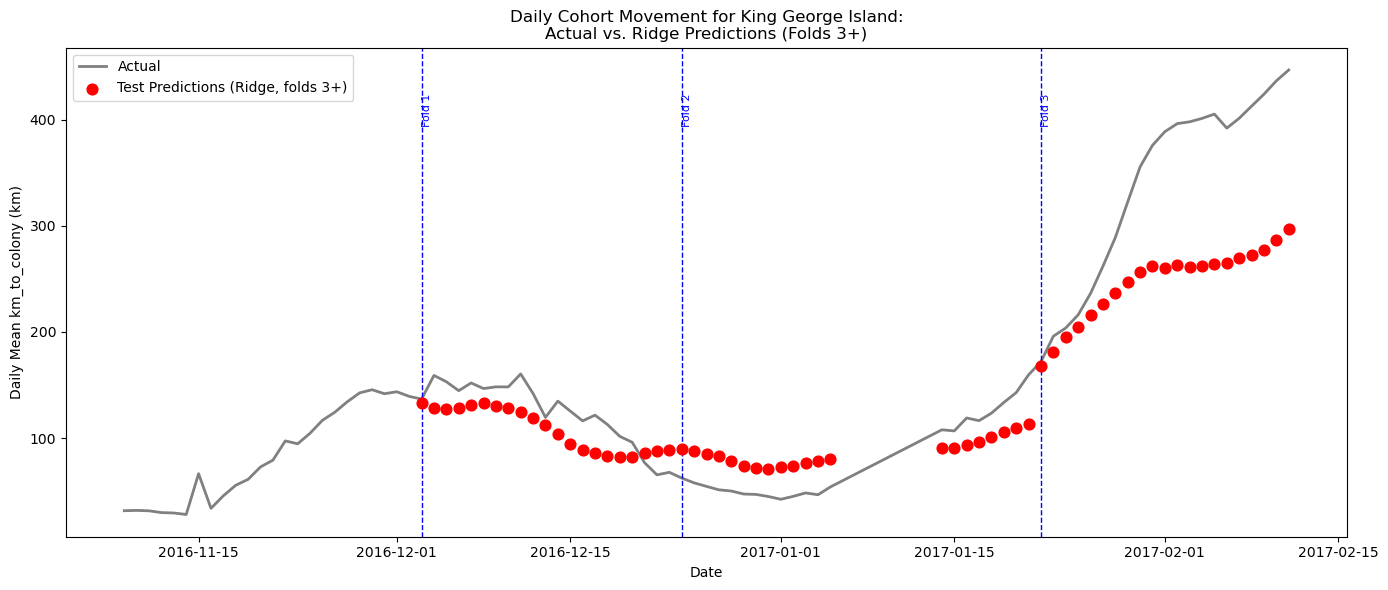

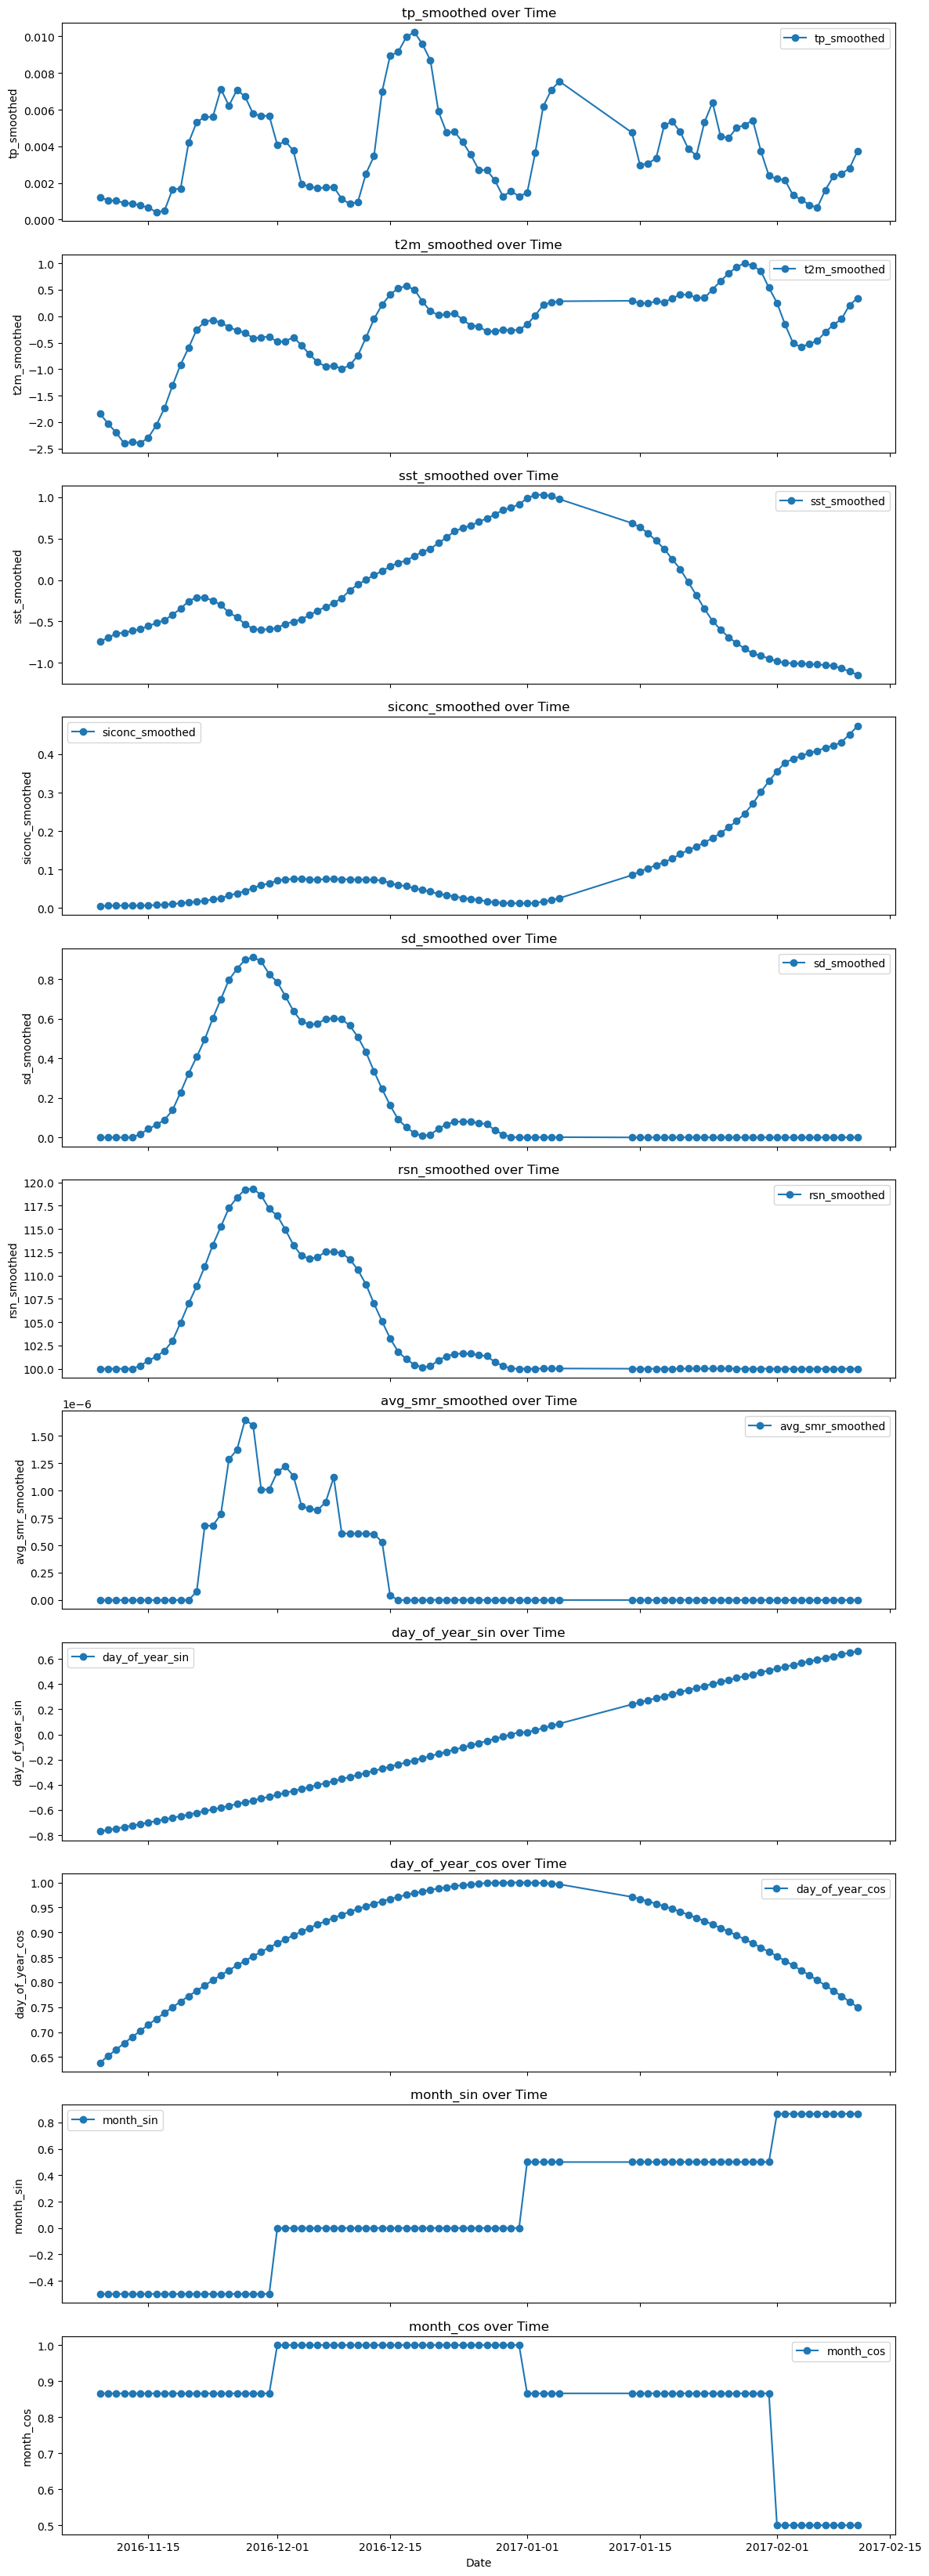

In [ ]:
"""
Daily Cohort Movement Regression for Adelie Penguins on King George Island

This script aggregates penguin trace data at the daily level for the King George Island colony (all months).
It uses the daily mean of 'km_to_colony_mean' as a proxy for cohort movement and fits Ridge and Lasso
regression models (using TimeSeriesSplit) to predict the daily mean km_to_colony_mean from measured
climate covariates. The climate features are first smoothed via a 7-day rolling mean. For evaluation,
only predictions from fold 3 onward (i.e. when sufficient training data is available) are measured.
The final visualization shows the full time series with test set predictions (from folds 3+) clearly indicated,
and additional subplots display how each predictor feature evolved over time.

"""


# ----------------------------
# Load and sort data
# (Filter for the King George Island colony of "Adelie Penguin")
df = pd.read_csv("../data/penguin/penguins_final_with_era5.csv")
df = df[(df['common_name'] == 'Adelie Penguin') & (df['colony_name'] == 'King George Island')].copy()
df['date_gmt'] = pd.to_datetime(df['date_gmt'])
df = df.sort_values(by='date_gmt')

# ----------------------------
# Feature Engineering on Raw Data
df['day_of_year'] = df['date_gmt'].dt.dayofyear
df['month'] = df['date_gmt'].dt.month

# ----------------------------
# Aggregate Data Daily (Summarize the Cohort Movement)
# Aggregate by the date (ignoring time) to compute daily averages.
df['date'] = df['date_gmt'].dt.date
daily_df = df.groupby('date').agg({
    'km_to_colony_mean': 'mean',
    'tp': 'mean',
    't2m': 'mean',
    'sst': 'mean',
    'siconc': 'mean',
    'sd': 'mean',
    'rsn': 'mean',
    'avg_smr': 'mean',
    'month': 'first',
    'day_of_year': 'first'
}).reset_index()
daily_df['n_records'] = df.groupby('date').size().values

# Filter out days with very few observations.
min_records_per_day = 1
daily_df = daily_df[daily_df['n_records'] >= min_records_per_day]
print(f"After aggregation, {len(daily_df)} daily observations remain.")

# ----------------------------
# Create additional temporal features (optional)
daily_df['day_of_year_sin'] = np.sin(2 * np.pi * daily_df['day_of_year'] / 365.0)
daily_df['day_of_year_cos'] = np.cos(2 * np.pi * daily_df['day_of_year'] / 365.0)
daily_df['month_sin'] = np.sin(2 * np.pi * daily_df['month'] / 12.0)
daily_df['month_cos'] = np.cos(2 * np.pi * daily_df['month'] / 12.0)

# ----------------------------
# Smooth the climate features using a 7-day rolling mean.
smoothing_window = 7
climate_vars = ['tp', 't2m', 'sst', 'siconc', 'sd', 'rsn', 'avg_smr']
for var in climate_vars:
    daily_df[f'{var}_smoothed'] = daily_df[var].rolling(window=smoothing_window, center=True).mean()

# ----------------------------
# Drop any remaining missing values (due to smoothing near boundaries).
daily_df = daily_df.dropna()

# ----------------------------
# Define feature set and target.
# Now using the smoothed climate covariates and the cyclical features.
features = [f'{var}_smoothed' for var in climate_vars] + [
    'day_of_year_sin', 'day_of_year_cos', 'month_sin', 'month_cos'
]
target = 'km_to_colony_mean'

X = daily_df[features]
y = daily_df[target]

# Ensure there are no NaNs.
X = X.dropna()
y = y.loc[X.index]
daily_df = daily_df.loc[X.index]

# ----------------------------
# Standardize features.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=features, index=X.index)

# ----------------------------
# Use TimeSeriesSplit to define train and test sets (maintaining temporal order).
tscv = TimeSeriesSplit(n_splits=3) #5

ridge_model = Ridge(alpha=1.0)
lasso_model = Lasso(alpha=0.1)

# Initialize containers for predictions and metrics.
test_indices_all = []
n_obs = len(X_scaled)
ridge_predictions = np.empty(n_obs)
ridge_predictions[:] = np.nan
lasso_predictions = np.empty(n_obs)
lasso_predictions[:] = np.nan

# We'll only record metrics starting from fold 3.
ridge_r2_scores = []
ridge_rmse_scores = []
lasso_r2_scores = []
lasso_rmse_scores = []

fold_num = 1
for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train Ridge and Lasso models.
    ridge_model.fit(X_train, y_train)
    lasso_model.fit(X_train, y_train)
    
    y_pred_ridge = ridge_model.predict(X_test)
    y_pred_lasso = lasso_model.predict(X_test)
    
    # For folds 1 and 2, do not record predictions/metrics.
    if fold_num >= 0:
        ridge_predictions[test_index] = y_pred_ridge
        lasso_predictions[test_index] = y_pred_lasso
        ridge_r2_scores.append(r2_score(y_test, y_pred_ridge))
        ridge_rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred_ridge)))
        lasso_r2_scores.append(r2_score(y_test, y_pred_lasso))
        lasso_rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred_lasso)))
    else:
        # Set predictions to NaN so they won't be used in the final evaluation plot.
        ridge_predictions[test_index] = np.nan
        lasso_predictions[test_index] = np.nan
        
    test_indices_all.append(test_index)
    fold_num += 1

print(f"Ridge Average R² Score (folds 3+): {np.mean(ridge_r2_scores):.3f}")
print(f"Ridge Average RMSE (folds 3+): {np.mean(ridge_rmse_scores):.3f}")
print(f"Lasso Average R² Score (folds 3+): {np.mean(lasso_r2_scores):.3f}")
print(f"Lasso Average RMSE (folds 3+): {np.mean(lasso_rmse_scores):.3f}")

# ----------------------------
# Print sorted Lasso coefficients for interpretability.
coeff_df = pd.DataFrame({
    'Feature': features,
    'Lasso Coef': lasso_model.coef_
})
coeff_df['Lasso Importance'] = coeff_df['Lasso Coef'].abs()
lasso_sorted = coeff_df.sort_values(by='Lasso Importance', ascending=False)
print("\nLasso Coefficients Sorted by Importance:")
print(lasso_sorted[['Feature', 'Lasso Coef', 'Lasso Importance']])

# ----------------------------
# Prepare the date for plotting.
daily_df['date'] = pd.to_datetime(daily_df['date'])

# ----------------------------
# Plot the entire time series with test predictions from folds 3+ indicated.
plt.figure(figsize=(14,6))
plt.plot(daily_df['date'], daily_df[target], label='Actual', color='gray', linewidth=2)
plt.scatter(daily_df['date'], ridge_predictions, label='Test Predictions (Ridge, folds 3+)', 
            color='red', s=60, zorder=5)

# Mark the boundaries between folds.
for fold_idx, test_idx in enumerate(test_indices_all):
    if len(test_idx) > 0:
        boundary_date = daily_df.iloc[test_idx[0]]['date']
        plt.axvline(x=boundary_date, color='blue', linestyle='--', linewidth=1)
        plt.text(boundary_date, daily_df[target].max()*0.95, f"Fold {fold_idx+1}", rotation=90,
                 verticalalignment='top', color='blue', fontsize=8)

plt.xlabel("Date")
plt.ylabel("Daily Mean km_to_colony (km)")
plt.title("Daily Cohort Movement for King George Island:\nActual vs. Ridge Predictions (Folds 3+)")
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------
# Additionally, create a subplot for every feature used.
feature_list = features
n_features = len(feature_list)
fig, axes = plt.subplots(n_features, 1, figsize=(12, 3 * n_features), sharex=True)

for i, feat in enumerate(feature_list):
    ax = axes[i]
    ax.plot(daily_df['date'], daily_df[feat], marker='o', linestyle='-', label=feat)
    ax.set_title(f"{feat} over Time")
    ax.set_ylabel(feat)
    ax.legend()

axes[-1].set_xlabel("Date")
plt.tight_layout()
plt.show()

## All features (+ time features), with lag ($R^2$: 0.724)

After aggregation, 100 daily observations remain.
Ridge Average R² Score: 0.116
Ridge Average RMSE: 47.195
Lasso Average R² Score: 0.724
Lasso Average RMSE: 23.788

Lasso Coefficients Sorted by Importance:
                    Feature  Lasso Coef  Lasso Importance
10   siconc_smoothed_shift1  123.953414        123.953414
5              rsn_smoothed   15.137769         15.137769
14          day_of_year_sin  -14.274109         14.274109
15          day_of_year_cos    8.880475          8.880475
0               tp_smoothed    3.854494          3.854494
9       sst_smoothed_shift1   -3.091831          3.091831
4               sd_smoothed    3.009563          3.009563
13  avg_smr_smoothed_shift1   -1.563923          1.563923
7        tp_smoothed_shift1   -1.004562          1.004562
1              t2m_smoothed    0.365992          0.365992
6          avg_smr_smoothed   -0.054454          0.054454
3           siconc_smoothed    0.040782          0.040782
8       t2m_smoothed_shift1    0.000000 

/opt/homebrew/anaconda3/envs/projectp/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.502e+00, tolerance: 7.729e+00
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/anaconda3/envs/projectp/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.236e+01, tolerance: 1.188e+01
  model = cd_fast.enet_coordinate_descent(


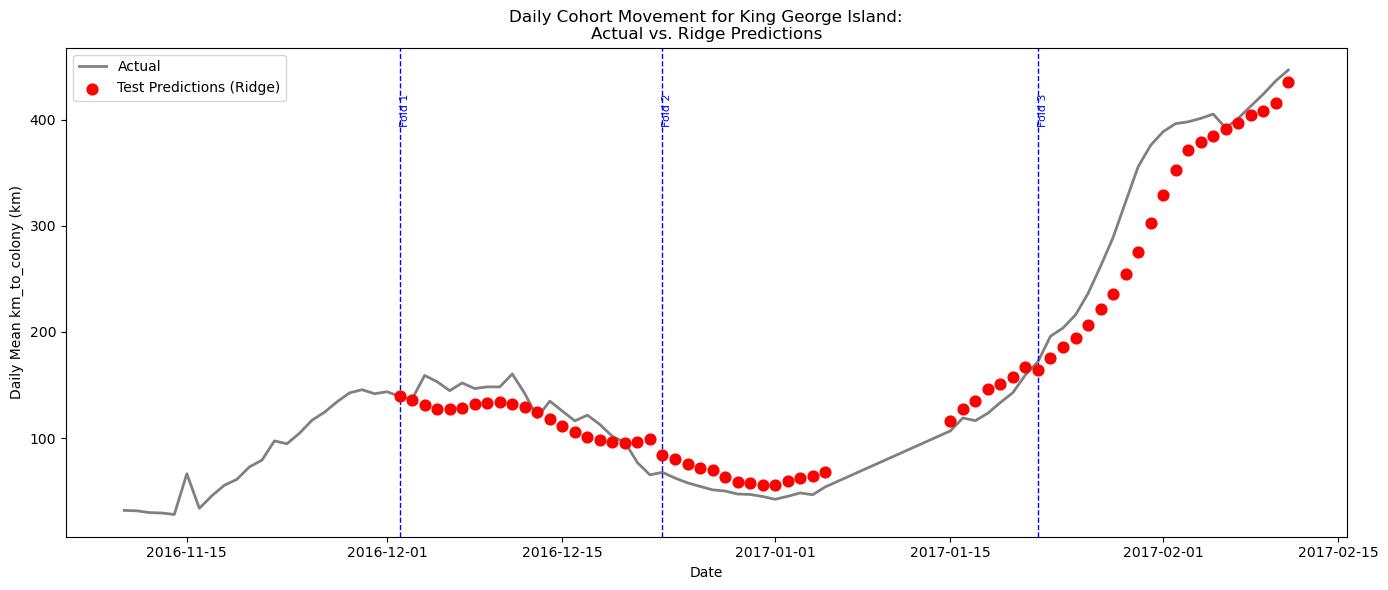

In [211]:
"""
Daily Cohort Movement Regression for Adelie Penguins on King George Island

This script aggregates penguin trace data at the daily level for the King George Island colony (all months).
It uses the daily mean of 'km_to_colony_mean' as a proxy for cohort movement and fits Ridge and Lasso
regression models (using TimeSeriesSplit) to predict the daily mean km_to_colony_mean from measured
climate covariates. The climate features are first smoothed via a 7-day rolling mean, and then one-day
lagged (shifted) versions of each covariate are computed. For evaluation, only predictions from fold 3 onward
(i.e. when sufficient training data is available) are measured. The final visualization shows the full time
series with test set predictions (from folds 3+) clearly indicated, and additional subplots display how each
predictor feature evolved over time.

"""

# ----------------------------
# Load and sort data
# (Filter for the King George Island colony of "Adelie Penguin")
df = pd.read_csv("../data/penguin/penguins_final_with_era5.csv")
df = df[(df['common_name'] == 'Adelie Penguin') & (df['colony_name'] == 'King George Island')].copy()
df['date_gmt'] = pd.to_datetime(df['date_gmt'])
df = df.sort_values(by='date_gmt')

# ----------------------------
# Feature Engineering on Raw Data
df['day_of_year'] = df['date_gmt'].dt.dayofyear
df['month'] = df['date_gmt'].dt.month

# ----------------------------
# Aggregate Data Daily (Summarize the Cohort Movement)
# Aggregate by the date (ignoring time) to compute daily averages.
df['date'] = df['date_gmt'].dt.date
daily_df = df.groupby('date').agg({
    'km_to_colony_mean': 'mean',
    'tp': 'mean',
    't2m': 'mean',
    'sst': 'mean',
    'siconc': 'mean',
    'sd': 'mean',
    'rsn': 'mean',
    'avg_smr': 'mean',
    'month': 'first',
    'day_of_year': 'first'
}).reset_index()
daily_df['n_records'] = df.groupby('date').size().values

# Filter out days with very few observations.
min_records_per_day = 1
daily_df = daily_df[daily_df['n_records'] >= min_records_per_day]
print(f"After aggregation, {len(daily_df)} daily observations remain.")

# ----------------------------
# Create additional temporal features (optional)
daily_df['day_of_year_sin'] = np.sin(2 * np.pi * daily_df['day_of_year'] / 365.0)
daily_df['day_of_year_cos'] = np.cos(2 * np.pi * daily_df['day_of_year'] / 365.0)
daily_df['month_sin'] = np.sin(2 * np.pi * daily_df['month'] / 12.0)
daily_df['month_cos'] = np.cos(2 * np.pi * daily_df['month'] / 12.0)

# ----------------------------
# Smooth the climate features using a 7-day rolling mean.
smoothing_window = 7
climate_vars = ['tp', 't2m', 'sst', 'siconc', 'sd', 'rsn', 'avg_smr']
for var in climate_vars:
    daily_df[f'{var}_smoothed'] = daily_df[var].rolling(window=smoothing_window, center=True).mean()

# ----------------------------
# Create shifted (lagged) versions of the smoothed climate features.
# Here we shift by 1 day. You can adjust the shift period if desired.
for var in climate_vars:
    daily_df[f'{var}_smoothed_shift1'] = daily_df[f'{var}_smoothed'].shift(1)

# ----------------------------
# Drop any remaining missing values (due to smoothing and shifting near boundaries).
daily_df = daily_df.dropna()

# ----------------------------
# Define feature set and target.
# Use both the original smoothed climate covariates and their one-day shifted versions, plus cyclical features.
features = ([f'{var}_smoothed' for var in climate_vars] +
            [f'{var}_smoothed_shift1' for var in climate_vars] +
            ['day_of_year_sin', 'day_of_year_cos', 'month_sin', 'month_cos'])
target = 'km_to_colony_mean'

X = daily_df[features]
y = daily_df[target]

# Ensure there are no NaNs.
X = X.dropna()
y = y.loc[X.index]
daily_df = daily_df.loc[X.index]

# ----------------------------
# Standardize features.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=features, index=X.index)

# ----------------------------
# Use TimeSeriesSplit to define train and test sets (maintaining temporal order).
tscv = TimeSeriesSplit(n_splits=3)  # You can adjust the number of splits as needed

ridge_model = Ridge(alpha=1.0)
lasso_model = Lasso(alpha=0.1)

# Initialize containers for predictions and metrics.
test_indices_all = []
n_obs = len(X_scaled)
ridge_predictions = np.empty(n_obs)
ridge_predictions[:] = np.nan
lasso_predictions = np.empty(n_obs)
lasso_predictions[:] = np.nan

# We'll record metrics starting from fold 3 (if applicable).
ridge_r2_scores = []
ridge_rmse_scores = []
lasso_r2_scores = []
lasso_rmse_scores = []

fold_num = 1
for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train Ridge and Lasso models.
    ridge_model.fit(X_train, y_train)
    lasso_model.fit(X_train, y_train)
    
    y_pred_ridge = ridge_model.predict(X_test)
    y_pred_lasso = lasso_model.predict(X_test)
    
    # Here, you can decide to record predictions/metrics only for a specific fold.
    # In this example, we're recording for all folds (change the condition as needed).
    if fold_num >= 1:  # Adjust this condition if you wish to start at a later fold.
        ridge_predictions[test_index] = y_pred_ridge
        lasso_predictions[test_index] = y_pred_lasso
        ridge_r2_scores.append(r2_score(y_test, y_pred_ridge))
        ridge_rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred_ridge)))
        lasso_r2_scores.append(r2_score(y_test, y_pred_lasso))
        lasso_rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred_lasso)))
    else:
        ridge_predictions[test_index] = np.nan
        lasso_predictions[test_index] = np.nan
        
    test_indices_all.append(test_index)
    fold_num += 1

print(f"Ridge Average R² Score: {np.mean(ridge_r2_scores):.3f}")
print(f"Ridge Average RMSE: {np.mean(ridge_rmse_scores):.3f}")
print(f"Lasso Average R² Score: {np.mean(lasso_r2_scores):.3f}")
print(f"Lasso Average RMSE: {np.mean(lasso_rmse_scores):.3f}")

# ----------------------------
# Print sorted Lasso coefficients for interpretability.
coeff_df = pd.DataFrame({
    'Feature': features,
    'Lasso Coef': lasso_model.coef_
})
coeff_df['Lasso Importance'] = coeff_df['Lasso Coef'].abs()
lasso_sorted = coeff_df.sort_values(by='Lasso Importance', ascending=False)
print("\nLasso Coefficients Sorted by Importance:")
print(lasso_sorted[['Feature', 'Lasso Coef', 'Lasso Importance']])

# ----------------------------
# Prepare the date for plotting.
daily_df['date'] = pd.to_datetime(daily_df['date'])

# ----------------------------
# Plot the entire time series with test predictions indicated.
plt.figure(figsize=(14,6))
plt.plot(daily_df['date'], daily_df[target], label='Actual', color='gray', linewidth=2)
plt.scatter(daily_df['date'], lasso_predictions, label='Test Predictions (Ridge)', 
            color='red', s=60, zorder=5)

# Mark the boundaries between folds.
for fold_idx, test_idx in enumerate(test_indices_all):
    if len(test_idx) > 0:
        boundary_date = daily_df.iloc[test_idx[0]]['date']
        plt.axvline(x=boundary_date, color='blue', linestyle='--', linewidth=1)
        plt.text(boundary_date, daily_df[target].max()*0.95, f"Fold {fold_idx+1}", rotation=90,
                 verticalalignment='top', color='blue', fontsize=8)

plt.xlabel("Date")
plt.ylabel("Daily Mean km_to_colony (km)")
plt.title("Daily Cohort Movement for King George Island:\nActual vs. Ridge Predictions")
plt.legend()
plt.tight_layout()
plt.show()


## Feature and target variable correlation

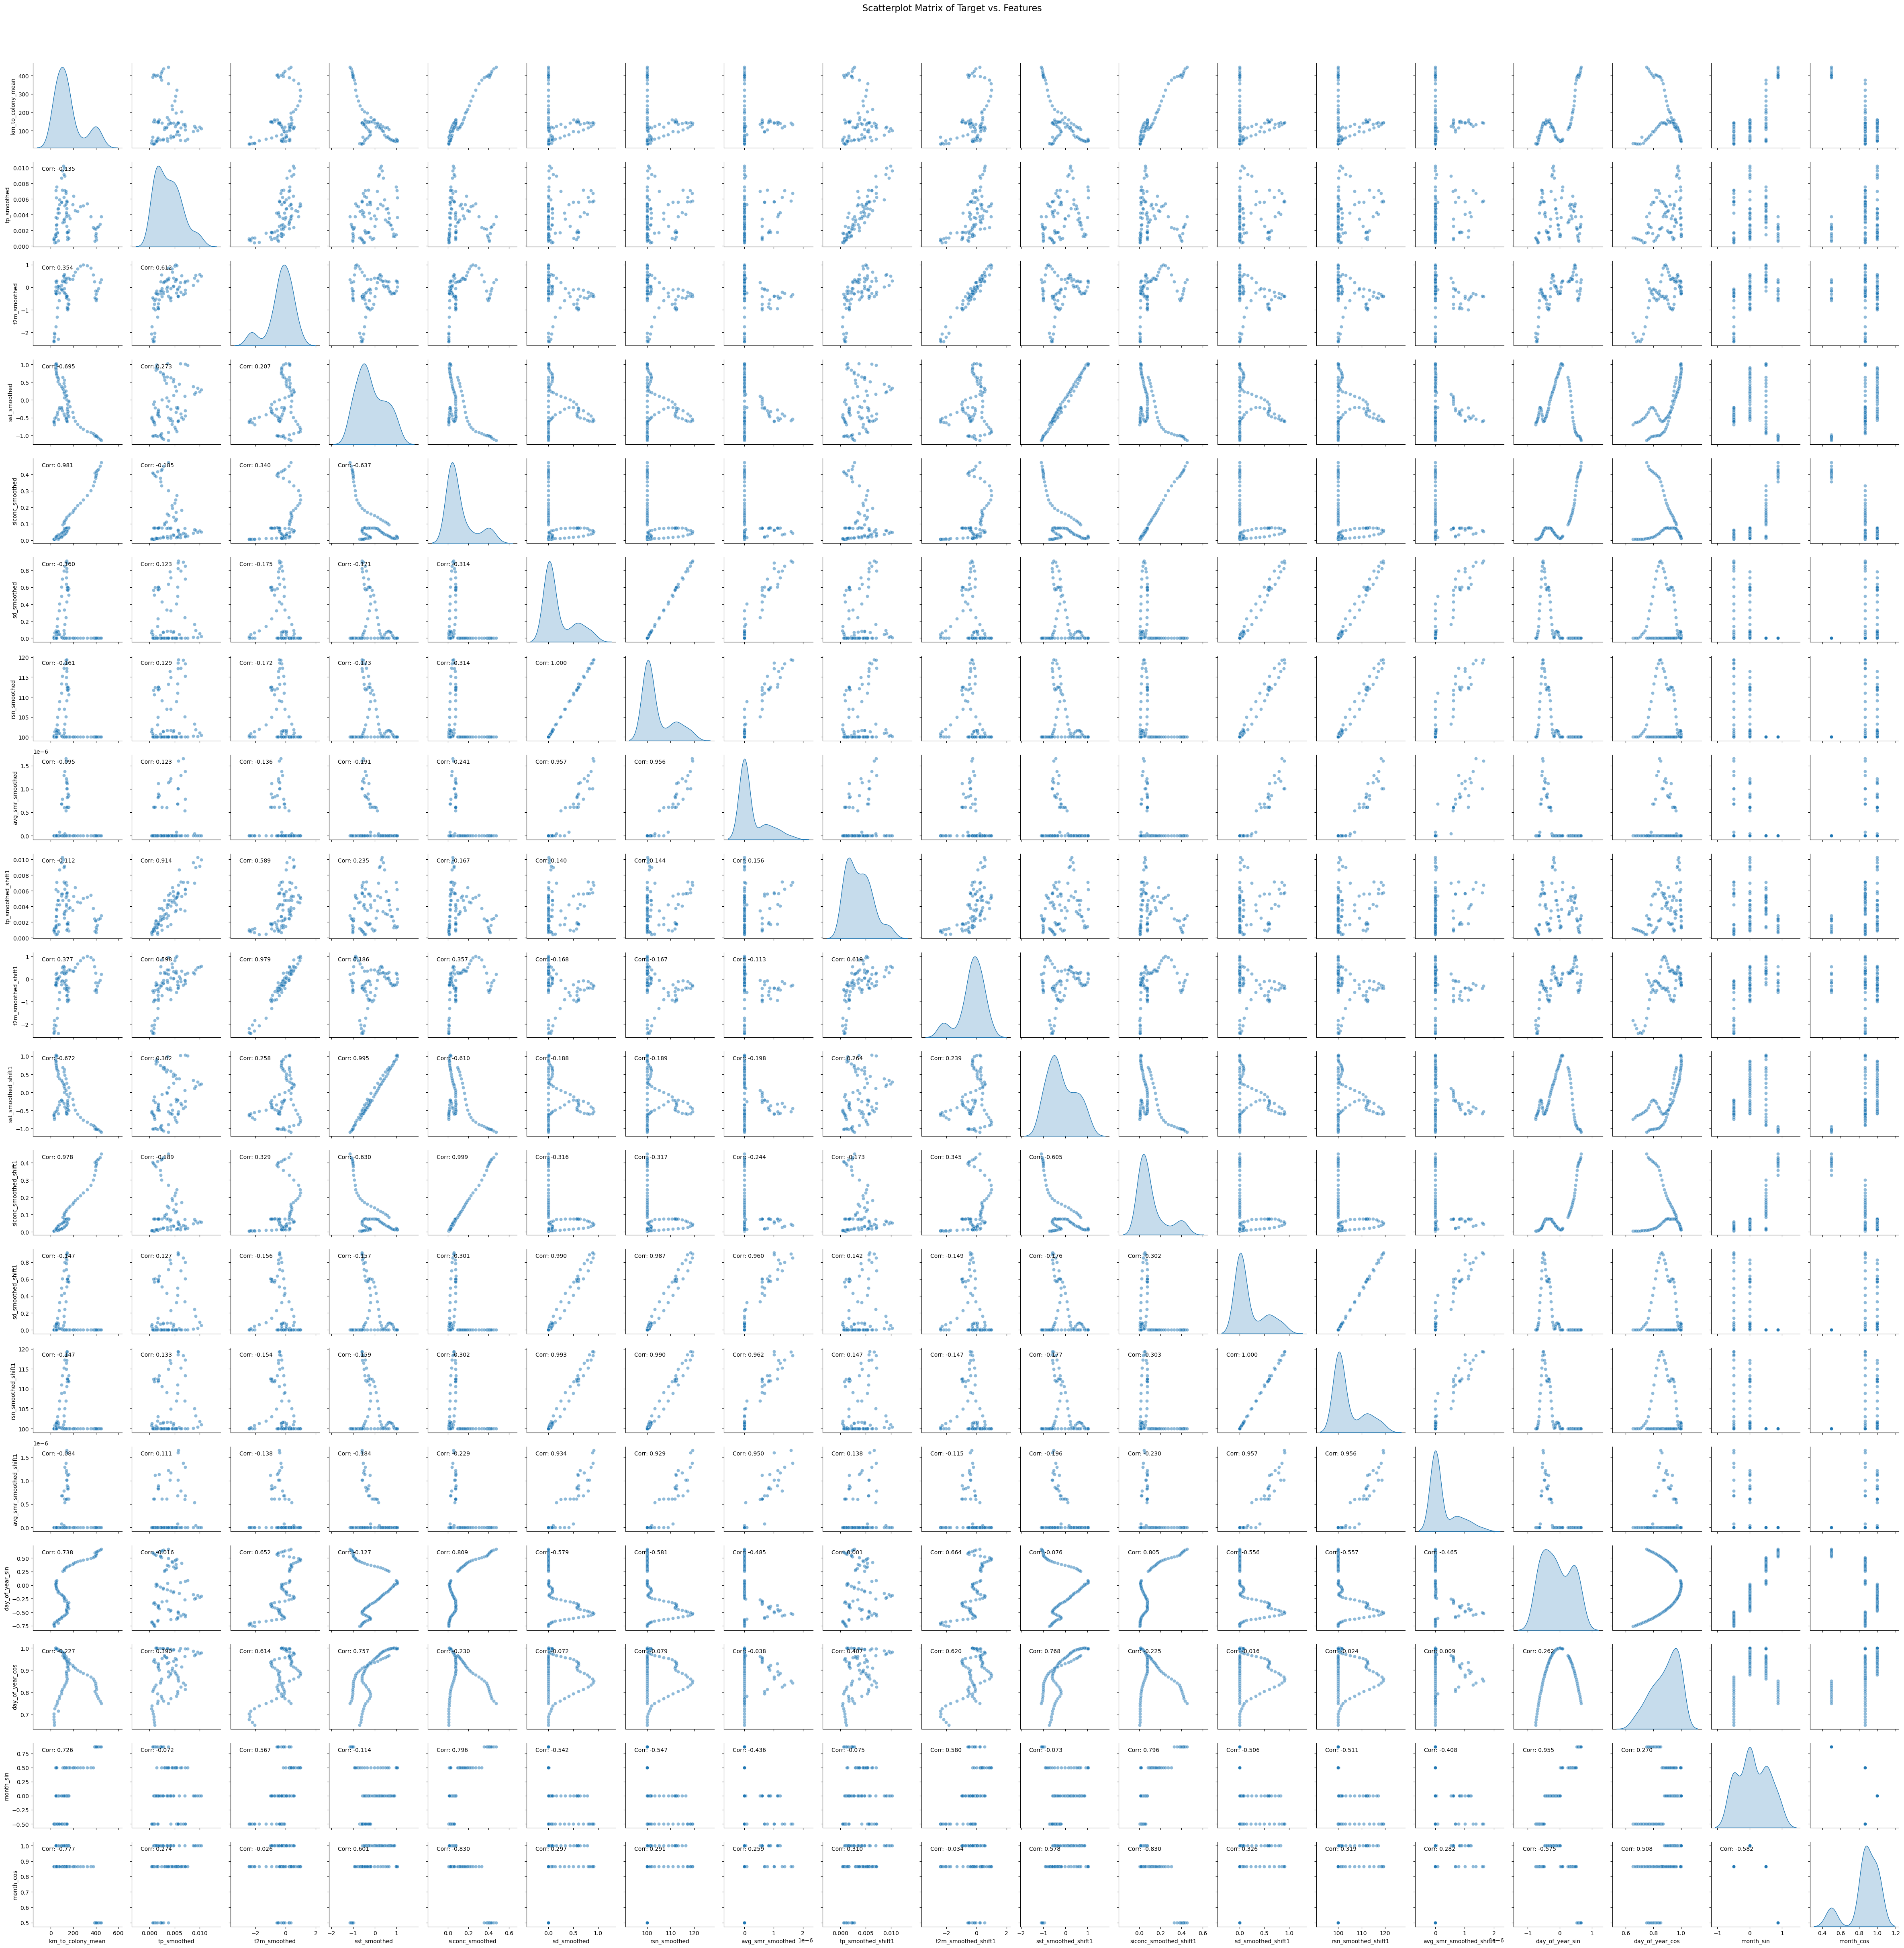

In [169]:
# Combine the target and features into a single DataFrame for plotting.
scatter_data = daily_df[[target] + features]

# Create a pairplot with correlation coefficients and scatter plots.
def correlation_coeff(x, y, **kwargs):
    corr_r = np.corrcoef(x, y)[0, 1]
    ax = plt.gca()
    ax.annotate(f'Corr: {corr_r:.3f}', xy=(0.1, 0.9), xycoords=ax.transAxes)

pairplot = sns.pairplot(
    scatter_data,
    diag_kind="kde",  
    plot_kws={"alpha": 0.5}  
)

# Add correlation coefficients to the scatterplots.
pairplot.map_lower(correlation_coeff)

plt.suptitle("Scatterplot Matrix of Target vs. Features", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()


## Regression without time component

Linear Regression Performance:
R² Score: 0.607
RMSE: 168.476

Model Coefficients:
  Feature  Coefficient
0     t2m     9.395880
1     sst   -86.434938
2  siconc   141.317505
3      tp     6.717301


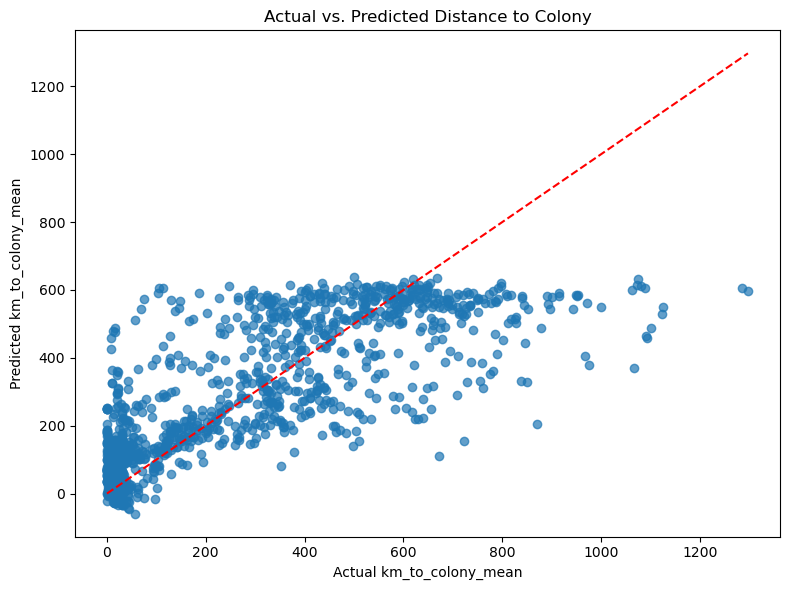

In [175]:
"""
Linear Regression for Predicting Distance to Colony
----------------------------------------------------
This script loads the full dataset and selects only the climate features:
    - t2m
    - sst
    - siconc
    - tp

It then builds a simple Linear Regression model to predict the daily mean 
'km_to_colony_mean' (the distance to colony) without using any time-based features.
The script splits the data into training and test sets, standardizes the predictors,
fits the model, evaluates performance using R² and RMSE, and plots the actual vs. predicted values.

"""


# ----------------------------
# Load Data
df = pd.read_csv("../data/penguin/penguins_final_with_era5.csv")

# Optionally, if you only want to analyze a specific species, e.g., Adelie Penguin:
df = df[df['common_name'] == 'Adelie Penguin'].copy()

# Convert date column (not used in the model, but useful for other purposes)
df['date_gmt'] = pd.to_datetime(df['date_gmt'])

# ----------------------------
# Define Predictors and Target
# We use only t2m, sst, siconc, and tp as features
features = ['t2m', 'sst', 'siconc', 'tp']
target = 'km_to_colony_mean'

# Drop rows with missing values in these columns
df = df.dropna(subset=features + [target])

X = df[features]
y = df[target]

# ----------------------------
# Split the Data
# Use a random train/test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ----------------------------
# Standardize the Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ----------------------------
# Build and Fit the Linear Regression Model 
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# ----------------------------
# Make Predictions
y_pred = lr_model.predict(X_test_scaled)

# ----------------------------
# Evaluate Performance
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Linear Regression Performance:")
print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")

# Print model coefficients for interpretability.
coefficients = pd.DataFrame({
    'Feature': features,
    'Coefficient': lr_model.coef_
})
print("\nModel Coefficients:")
print(coefficients)

# ----------------------------
# Plot Actual vs. Predicted Values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Actual km_to_colony_mean")
plt.ylabel("Predicted km_to_colony_mean")
plt.title("Actual vs. Predicted Distance to Colony")
# Plot a 45-degree reference line:
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.tight_layout()
plt.show()


## Prediction with only main features (no extra time features) and lag ($R^2$: 0.363)

After aggregation, 100 daily observations remain.
Ridge Average R² Score: 0.236
Ridge Average RMSE: 27.198
Lasso Average R² Score: 0.363
Lasso Average RMSE: 27.490

Lasso Coefficients Sorted by Importance:
                  Feature  Lasso Coef  Lasso Importance
4  siconc_smoothed_shift1   96.104015         96.104015
5     sst_smoothed_shift1  -50.670937         50.670937
2            sst_smoothed   19.833241         19.833241
3     t2m_smoothed_shift1   11.676741         11.676741
0            t2m_smoothed   11.133617         11.133617
1         siconc_smoothed    0.000000          0.000000


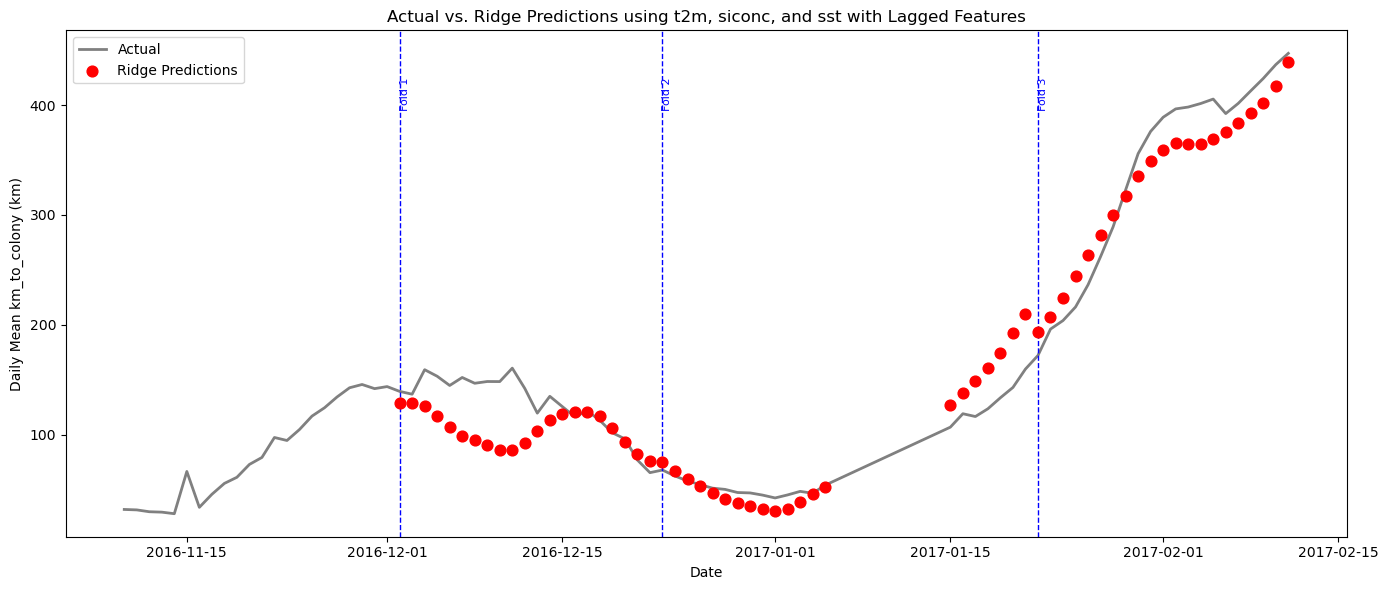

In [213]:
"""
Daily Cohort Movement Regression for Adelie Penguins on King George Island

This script aggregates penguin trace data at the daily level for the King George Island colony.
It uses the daily mean of 'km_to_colony_mean' as a proxy for cohort movement and fits Ridge and Lasso
regression models (using TimeSeriesSplit) to predict the daily mean km_to_colony_mean from selected
climate covariates. In this version, only the features t2m, siconc, and sst are used—each is smoothed
via a 7-day rolling mean and augmented with its one-day lagged (shifted) version. No additional time-based
features are included. The final visualization shows the actual versus predicted values and subplots for
each selected feature.

"""

# ----------------------------
# Load and sort data
# (Filter for the King George Island colony of "Adelie Penguin")
df = pd.read_csv("../data/penguin/penguins_final_with_era5.csv")
df = df[(df['common_name'] == 'Adelie Penguin') & (df['colony_name'] == 'King George Island')].copy()
df['date_gmt'] = pd.to_datetime(df['date_gmt'])
df = df.sort_values(by='date_gmt')

# ----------------------------
# Feature Engineering on Raw Data
df['day_of_year'] = df['date_gmt'].dt.dayofyear
df['month'] = df['date_gmt'].dt.month

# ----------------------------
# Aggregate Data Daily (Compute daily averages)
df['date'] = df['date_gmt'].dt.date
daily_df = df.groupby('date').agg({
    'km_to_colony_mean': 'mean',
    't2m': 'mean',
    'siconc': 'mean',
    'sst': 'mean',
    'month': 'first',
    'day_of_year': 'first'
}).reset_index()
daily_df['n_records'] = df.groupby('date').size().values

# Filter out days with very few observations.
min_records_per_day = 1
daily_df = daily_df[daily_df['n_records'] >= min_records_per_day]
print(f"After aggregation, {len(daily_df)} daily observations remain.")

# ----------------------------
# Smooth the selected climate features using a 7-day rolling mean.
smoothing_window = 7
selected_vars = ['t2m', 'siconc', 'sst']
for var in selected_vars:
    daily_df[f'{var}_smoothed'] = daily_df[var].rolling(window=smoothing_window, center=True).mean()

# Create one-day lagged versions of the smoothed features.
for var in selected_vars:
    daily_df[f'{var}_smoothed_shift1'] = daily_df[f'{var}_smoothed'].shift(1)
# for var in selected_vars:
#     for i in range(1, 4):
#         daily_df[f'{var}_smoothed_shift{i}'] = daily_df[f'{var}_smoothed'].shift(i)
    #daily_df[f'{var}_smoothed_shift1'] = daily_df[f'{var}_smoothed'].shift(1)

# ----------------------------
# Drop any remaining missing values (due to smoothing and shifting).
daily_df = daily_df.dropna()

# ----------------------------
# Define feature set and target.
# Use only the smoothed features and their one-day lagged versions.
features = ([f'{var}_smoothed' for var in selected_vars] +
            [f'{var}_smoothed_shift1' for var in selected_vars])
target = 'km_to_colony_mean'

X = daily_df[features]
y = daily_df[target]

# Ensure alignment.
X = X.dropna()
y = y.loc[X.index]
daily_df = daily_df.loc[X.index]

# ----------------------------
# Standardize features.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=features, index=X.index)

# ----------------------------
# Use TimeSeriesSplit to define train/test sets.
tscv = TimeSeriesSplit(n_splits=3)  # Adjust n_splits as needed

ridge_model = Ridge(alpha=1.0)
lasso_model = Lasso(alpha=0.1)

n_obs = len(X_scaled)
ridge_predictions = np.empty(n_obs)
ridge_predictions[:] = np.nan
lasso_predictions = np.empty(n_obs)
lasso_predictions[:] = np.nan

ridge_r2_scores = []
ridge_rmse_scores = []
lasso_r2_scores = []
lasso_rmse_scores = []
test_indices_all = []

fold_num = 1
for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train Ridge and Lasso models.
    ridge_model.fit(X_train, y_train)
    lasso_model.fit(X_train, y_train)
    
    y_pred_ridge = ridge_model.predict(X_test)
    y_pred_lasso = lasso_model.predict(X_test)
    
    # Record predictions and evaluation metrics.
    ridge_predictions[test_index] = y_pred_ridge
    lasso_predictions[test_index] = y_pred_lasso
    ridge_r2_scores.append(r2_score(y_test, y_pred_ridge))
    ridge_rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred_ridge)))

    lasso_r2_scores.append(r2_score(y_test, y_pred_lasso))
    lasso_rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred_lasso)))
    
    test_indices_all.append(test_index)
    fold_num += 1

print(f"Ridge Average R² Score: {np.mean(ridge_r2_scores):.3f}")
print(f"Ridge Average RMSE: {np.mean(ridge_rmse_scores):.3f}")
print(f"Lasso Average R² Score: {np.mean(lasso_r2_scores):.3f}")
print(f"Lasso Average RMSE: {np.mean(lasso_rmse_scores):.3f}")

# ----------------------------
# Print sorted Lasso coefficients for interpretability.
coeff_df = pd.DataFrame({
    'Feature': features,
    'Lasso Coef': lasso_model.coef_
})
coeff_df['Lasso Importance'] = coeff_df['Lasso Coef'].abs()
lasso_sorted = coeff_df.sort_values(by='Lasso Importance', ascending=False)
print("\nLasso Coefficients Sorted by Importance:")
print(lasso_sorted[['Feature', 'Lasso Coef', 'Lasso Importance']])

# ----------------------------
# Prepare the date for plotting.
daily_df['date'] = pd.to_datetime(daily_df['date'])

# ----------------------------
# Plot the actual vs. Ridge predictions.
plt.figure(figsize=(14,6))
plt.plot(daily_df['date'], daily_df[target], label='Actual', color='gray', linewidth=2)
plt.scatter(daily_df['date'], ridge_predictions, label='Ridge Predictions', 
            color='red', s=60, zorder=5)

# Mark the boundaries between test folds.
for fold_idx, test_idx in enumerate(test_indices_all):
    if len(test_idx) > 0:
        boundary_date = daily_df.iloc[test_idx[0]]['date']
        plt.axvline(x=boundary_date, color='blue', linestyle='--', linewidth=1)
        plt.text(boundary_date, daily_df[target].max()*0.95, f"Fold {fold_idx+1}", rotation=90,
                 verticalalignment='top', color='blue', fontsize=8)
plt.xlabel("Date")
plt.ylabel("Daily Mean km_to_colony (km)")
plt.title("Actual vs. Ridge Predictions using t2m, siconc, and sst with Lagged Features")
plt.legend()
plt.tight_layout()
plt.show()



## BEST: Only main features (no extra time features) and lag and assessing Folds > 1 ($R^2$: 0.787)

After aggregation, 100 daily observations remain.
Ridge Average R² Score (folds 2+ and 3): 0.787
Ridge Average RMSE (folds 2+ and 3): 23.256
\Ridge Coefficients Sorted by Importance:
                  Feature  Ridge Coef  Ridge Importance
4  siconc_smoothed_shift1   43.823402         43.823402
1         siconc_smoothed   38.589445         38.589445
5     sst_smoothed_shift1  -27.730433         27.730433
0            t2m_smoothed   12.163584         12.163584
3     t2m_smoothed_shift1   11.900506         11.900506
2            sst_smoothed   -3.997186          3.997186


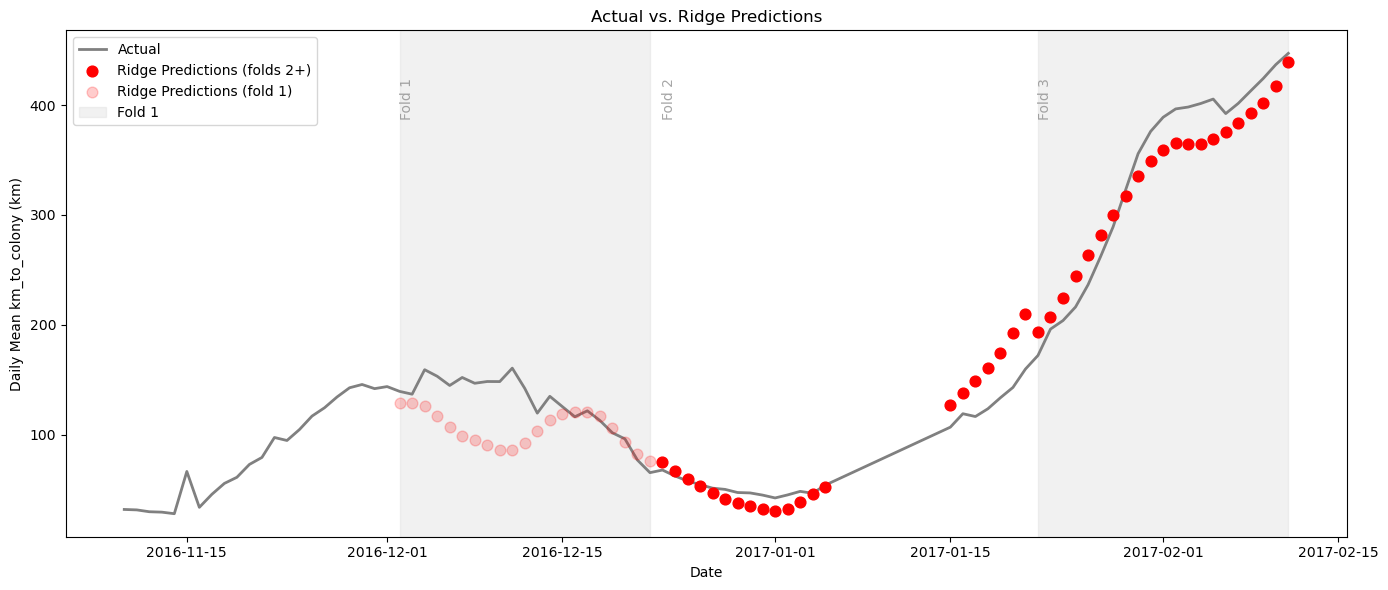

In [214]:
"""
Daily Cohort Movement Regression for Adelie Penguins on King George Island

This script aggregates penguin trace data at the daily level for the King George Island colony.
It uses the daily mean of 'km_to_colony_mean' as a proxy for cohort movement and fits Ridge and Lasso
regression models (using TimeSeriesSplit) to predict the daily mean km_to_colony_mean from selected
climate covariates. In this version, only the features t2m, siconc, and sst are used—each is smoothed
via a 7-day rolling mean and augmented with its one-day lagged (shifted) version. No additional time-based
features are included. Only the predictions from folds 2 and 3 (i.e. when sufficient training data is available)
are used to compute evaluation metrics. However, for visualization, we also include the predictions from fold 1
(with a lower alpha so they are de-emphasized). The final visualization shows the actual versus predicted values,
and subplots for each selected feature.

"""

# ----------------------------
# Load and sort data
# (Filter for the King George Island colony of "Adelie Penguin")
df = pd.read_csv("../data/penguin/penguins_final_with_era5.csv")
df = df[(df['common_name'] == 'Adelie Penguin') & (df['colony_name'] == 'King George Island')].copy()
df['date_gmt'] = pd.to_datetime(df['date_gmt'])
df = df.sort_values(by='date_gmt')

# ----------------------------
# Feature Engineering on Raw Data
df['day_of_year'] = df['date_gmt'].dt.dayofyear
df['month'] = df['date_gmt'].dt.month

# ----------------------------
# Aggregate Data Daily (Compute daily averages)
df['date'] = df['date_gmt'].dt.date
daily_df = df.groupby('date').agg({
    'km_to_colony_mean': 'mean',
    't2m': 'mean',
    'siconc': 'mean',
    'sst': 'mean',
    'month': 'first',
    'day_of_year': 'first'
}).reset_index()
daily_df['n_records'] = df.groupby('date').size().values

# Filter out days with very few observations.
min_records_per_day = 1
daily_df = daily_df[daily_df['n_records'] >= min_records_per_day]
print(f"After aggregation, {len(daily_df)} daily observations remain.")

# ----------------------------
# Smooth the selected climate features using a 7-day rolling mean.
smoothing_window = 7
selected_vars = ['t2m', 'siconc', 'sst']
for var in selected_vars:
    daily_df[f'{var}_smoothed'] = daily_df[var].rolling(window=smoothing_window, center=True).mean()

# Create one-day lagged versions of the smoothed features.
for var in selected_vars:
    daily_df[f'{var}_smoothed_shift1'] = daily_df[f'{var}_smoothed'].shift(1)

# ----------------------------
# Drop any remaining missing values (due to smoothing and shifting).
daily_df = daily_df.dropna()

# ----------------------------
# Define feature set and target.
# Use only the smoothed features and their one-day lagged versions.
features = ([f'{var}_smoothed' for var in selected_vars] +
            [f'{var}_smoothed_shift1' for var in selected_vars])
target = 'km_to_colony_mean'

X = daily_df[features]
y = daily_df[target]

# Ensure alignment.
X = X.dropna()
y = y.loc[X.index]
daily_df = daily_df.loc[X.index]

# ----------------------------
# Standardize features.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=features, index=X.index)

# ----------------------------
# Use TimeSeriesSplit to define train/test sets.
tscv = TimeSeriesSplit(n_splits=3)  # Adjust n_splits as needed

ridge_model = Ridge(alpha=1.0)
lasso_model = Lasso(alpha=0.1)

n_obs = len(X_scaled)
ridge_predictions_all = np.empty(n_obs)
ridge_predictions_all[:] = np.nan

# We'll also record the test indices for fold 1 in order to plot them with low alpha.
fold1_indices = []

# For evaluation metrics, we only use folds 2 and 3.
ridge_r2_scores = []
ridge_rmse_scores = []
test_indices_all = []

fold_num = 1
for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train Ridge model.
    ridge_model.fit(X_train, y_train)
    y_pred_ridge = ridge_model.predict(X_test)
    
    # Record predictions for all folds.
    ridge_predictions_all[test_index] = y_pred_ridge
    
    if fold_num == 1:
        # Store indices from fold 1 for later plotting with low opacity.
        fold1_indices.extend(test_index)
    elif fold_num >= 2:
        ridge_r2_scores.append(r2_score(y_test, y_pred_ridge))
        ridge_rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred_ridge)))
    
    test_indices_all.append(test_index)
    fold_num += 1

print(f"Ridge Average R² Score (folds 2+ and 3): {np.mean(ridge_r2_scores):.3f}")
print(f"Ridge Average RMSE (folds 2+ and 3): {np.mean(ridge_rmse_scores):.3f}")

# ----------------------------
# Print sorted Lasso coefficients for interpretability.
# (Note: Lasso model is still trained but not used for visualization in this example.)
coeff_df = pd.DataFrame({
    'Feature': features,
    'Ridge Coef': ridge_model.coef_ #lasso_model.coef_
})
coeff_df['Ridge Importance'] = coeff_df['Ridge Coef'].abs()
lasso_sorted = coeff_df.sort_values(by='Ridge Importance', ascending=False)
print("\Ridge Coefficients Sorted by Importance:")
print(lasso_sorted[['Feature', 'Ridge Coef', 'Ridge Importance']])

# ----------------------------
# Prepare the date for plotting.
daily_df['date'] = pd.to_datetime(daily_df['date'])

# ----------------------------
# Create masks for fold 1 predictions and folds 2+ predictions.
all_indices = np.arange(n_obs)
fold1_mask = np.zeros(n_obs, dtype=bool)
fold1_mask[fold1_indices] = True
fold2_3_indices = np.where(~fold1_mask)[0]

# ----------------------------
# Plot the actual vs. Ridge predictions.
plt.figure(figsize=(14,6))
plt.plot(daily_df['date'], daily_df[target], label='Actual', color='gray', linewidth=2)
# Plot predictions for folds 2 and 3 (full opacity)
plt.scatter(daily_df['date'].iloc[fold2_3_indices], ridge_predictions_all[fold2_3_indices],
            label='Ridge Predictions (folds 2+)', color='red', s=60, zorder=5)
# Plot predictions for fold 1 (with low alpha)
plt.scatter(daily_df['date'].iloc[fold1_indices], ridge_predictions_all[fold1_indices],
            label='Ridge Predictions (fold 1)', color='red', alpha=0.2, s=60, zorder=4)

# Mark the boundaries between test folds.
for fold_idx, test_idx in enumerate(test_indices_all):
    if len(test_idx) > 0:
        start_date = daily_df.iloc[test_idx[0]]['date']
        end_date = daily_df.iloc[test_idx[-1]]['date']
        
        # Add a shaded region for the fold
        color = 'lightgray' if fold_idx % 2 == 0 else 'white'  # Alternate colors
        plt.axvspan(start_date, end_date, color=color, alpha=0.3, label=f"Fold {fold_idx+1}" if fold_idx == 0 else None)
        
        # Annotate the fold label
        plt.text(start_date, daily_df[target].max() * 0.95, f"Fold {fold_idx+1}",
                 rotation=90, verticalalignment='top', fontsize=10, color='gray', alpha=0.7)
    # if len(test_idx) > 0:
    #     boundary_date = daily_df.iloc[test_idx[0]]['date']
    #     plt.axvline(x=boundary_date, color='blue', linestyle='--', linewidth=1)
    #     plt.text(boundary_date, daily_df[target].max()*0.95, f"Fold {fold_idx+1}", rotation=90,
    #              verticalalignment='top', color='blue', fontsize=8)
#plt.axvspan(pd.to_datetime('01-06-2017'), pd.to_datetime('01-14-2017'), color='lightblue', alpha=0.3)
plt.xlabel("Date")
plt.ylabel("Daily Mean km_to_colony (km)")
plt.title("Actual vs. Ridge Predictions")
plt.legend()
plt.tight_layout()
plt.show()



### Improved visualization of the prediction

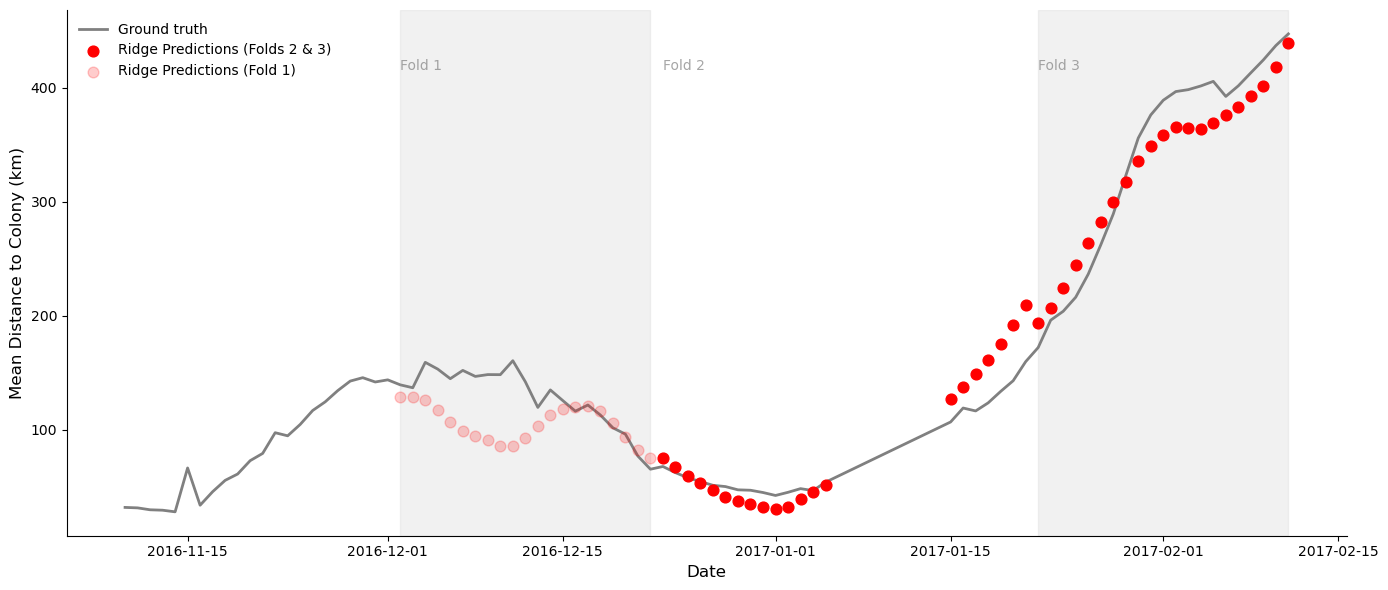

In [191]:
# Plot the actual vs. Ridge predictions.
plt.figure(figsize=(14, 6))

# Plot actual data
plt.plot(daily_df['date'], daily_df[target], label='Ground truth', color='gray', linewidth=2)

# Plot predictions for folds 2 and 3 (full opacity)
plt.scatter(daily_df['date'].iloc[fold2_3_indices], ridge_predictions_all[fold2_3_indices],
            label='Ridge Predictions (Folds 2 & 3)', color='red', s=60, zorder=5)

# Plot predictions for fold 1 (with low alpha)
plt.scatter(daily_df['date'].iloc[fold1_indices], ridge_predictions_all[fold1_indices],
            label='Ridge Predictions (Fold 1)', color='red', alpha=0.2, s=60, zorder=4)

# Mark the boundaries between test folds with shaded regions
for fold_idx, test_idx in enumerate(test_indices_all):
    if len(test_idx) > 0:
        start_date = daily_df.iloc[test_idx[0]]['date']
        end_date = daily_df.iloc[test_idx[-1]]['date']
        # Add a shaded region for the fold
        color = 'lightgray' if fold_idx % 2 == 0 else 'white'  # Alternate colors
        plt.axvspan(start_date, end_date, color=color, alpha=0.3, zorder=1)
        plt.text(start_date, daily_df[target].max() * 0.95, f"Fold {fold_idx+1}",
                 rotation=0, verticalalignment='top', fontsize=10, color='gray', alpha=0.7)

# Axis labels and title
plt.xlabel("Date", fontsize=12)
plt.ylabel("Mean Distance to Colony (km)", fontsize=12)
#plt.title("Actual vs. Ridge Predictions", fontsize=14)

# Minimalist frame
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Ticks and gridlines
#plt.grid(visible=True, which='major', linestyle='--', linewidth=0.5, alpha=0.5)
plt.tick_params(axis='both', which='major', labelsize=10)

# Legend
plt.legend(frameon=False, fontsize=10)

# Final layout adjustments
plt.tight_layout()
plt.show()


## Final ridge models - also quantifying uncertainty

#### Including lagged features

After aggregation, 100 daily observations remain.
Overall R²: 0.978, Overall RMSE: 20.680


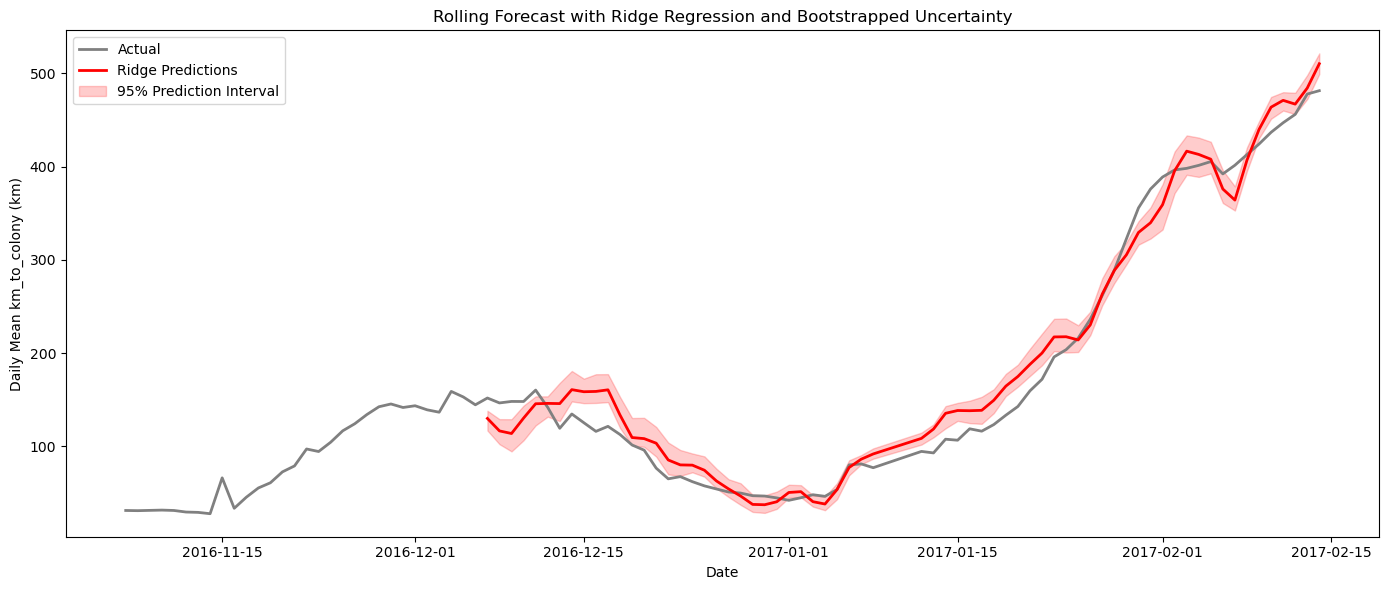

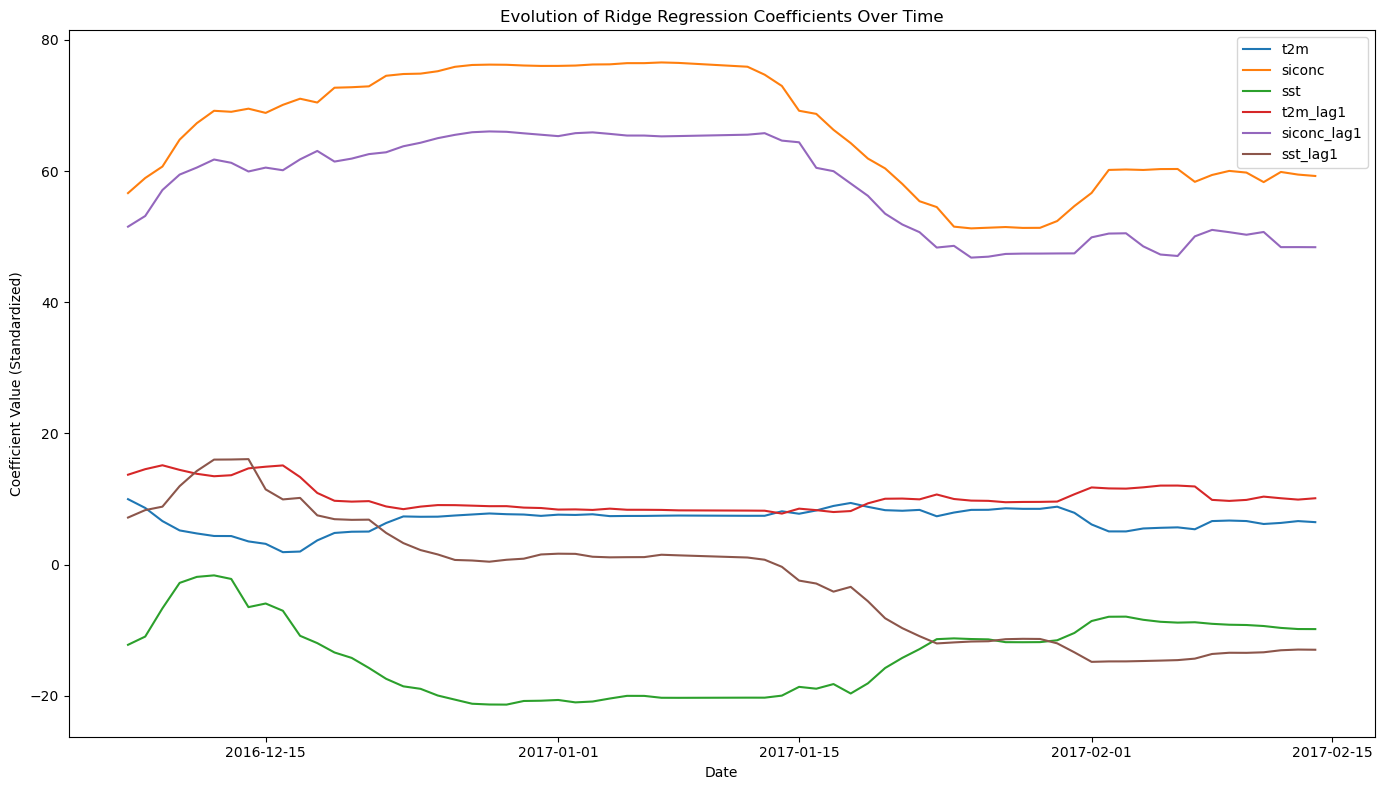

In [216]:
# =============================================================================
# 1. Data Loading and Preprocessing
# =============================================================================

# Load the penguin data and filter for the King George Island colony of "Adelie Penguin"
df = pd.read_csv("../data/penguin/penguins_final_with_era5.csv")
df = df[(df['common_name'] == 'Adelie Penguin') & 
        (df['colony_name'] == 'King George Island')].copy()
df['date_gmt'] = pd.to_datetime(df['date_gmt'])
df = df.sort_values(by='date_gmt')

# Create additional date features and convert to a daily time series
df['day_of_year'] = df['date_gmt'].dt.dayofyear
df['month'] = df['date_gmt'].dt.month
df['date'] = df['date_gmt'].dt.date

# Aggregate the data daily (compute daily averages)
daily_df = df.groupby('date').agg({
    'km_to_colony_mean': 'mean',
    't2m': 'mean',
    'siconc': 'mean',
    'sst': 'mean',
    'month': 'first',
    'day_of_year': 'first'
}).reset_index()
daily_df['n_records'] = df.groupby('date').size().values

# Filter out days with very few observations.
min_records_per_day = 1
daily_df = daily_df[daily_df['n_records'] >= min_records_per_day]
print(f"After aggregation, {len(daily_df)} daily observations remain.")

# =============================================================================
# 2. Feature Engineering Without Smoothing
# =============================================================================

# Instead of smoothing, we use raw daily weather variables and their one-day lagged versions.
daily_df['t2m_lag1'] = daily_df['t2m'].shift(1)
daily_df['siconc_lag1'] = daily_df['siconc'].shift(1)
daily_df['sst_lag1'] = daily_df['sst'].shift(1)

# Remove rows with missing lagged values.
daily_df = daily_df.dropna()

# Define our predictors and target.
features = ['t2m', 'siconc', 'sst', 't2m_lag1', 'siconc_lag1', 'sst_lag1']
target = 'km_to_colony_mean'
X = daily_df[features]
y = daily_df[target]

# =============================================================================
# 3. Standardize the Features
# =============================================================================

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=features, index=X.index)

# =============================================================================
# 4. Expanding Window Forecast with Ridge Regression and Bootstrapped Uncertainty
# =============================================================================

initial_training_size = 30  # Initial period to build the first model
n_bootstrap = 100           # Number of bootstrap iterations for uncertainty estimation

# Lists to store the forecasts, uncertainties, true values, dates, and coefficients over time.
predictions = []      # Point predictions
prediction_lower = [] # Lower bound of the 95% prediction interval
prediction_upper = [] # Upper bound of the 95% prediction interval
actuals = []          # Actual values for evaluation
dates_list = []       # Dates corresponding to each forecast
coefficients_list = []  # Ridge model coefficients at each forecast step

# Loop over each day after the initial training period.
for i in range(initial_training_size, len(X_scaled)):
    # Training data: all data up to day i.
    X_train = X_scaled.iloc[:i]
    y_train = y.iloc[:i]
    
    # Test data: the current day.
    X_test = X_scaled.iloc[[i]]
    y_test = y.iloc[i]
    
    # Fit the Ridge regression model on the training data.
    ridge_model = Ridge(alpha=1.0)
    ridge_model.fit(X_train, y_train)
    y_pred = ridge_model.predict(X_test)[0]
    
    # Bootstrapping to estimate uncertainty:
    bootstrap_preds = []
    for b in range(n_bootstrap):
        # Resample the training indices with replacement.
        bootstrap_indices = np.random.choice(X_train.index, size=len(X_train), replace=True)
        X_train_boot = X_train.loc[bootstrap_indices]
        y_train_boot = y_train.loc[bootstrap_indices]
        
        # Refit the Ridge model on the bootstrap sample.
        boot_model = Ridge(alpha=1.0)
        boot_model.fit(X_train_boot, y_train_boot)
        
        # Predict on the test day and record the prediction.
        bootstrap_preds.append(boot_model.predict(X_test)[0])
    bootstrap_preds = np.array(bootstrap_preds)
    
    # Compute the 2.5th and 97.5th percentiles to form a 95% prediction interval.
    lower_bound = np.percentile(bootstrap_preds, 2.5)
    upper_bound = np.percentile(bootstrap_preds, 97.5)
    
    # Record the prediction, prediction interval, actual value, and date.
    predictions.append(y_pred)
    prediction_lower.append(lower_bound)
    prediction_upper.append(upper_bound)
    actuals.append(y_test)
    dates_list.append(daily_df.iloc[i]['date'])
    
    # Also record the coefficients (after standardization, these reflect relative feature importance).
    coefficients_list.append(ridge_model.coef_)

# Evaluate overall forecast performance.
overall_r2 = r2_score(actuals, predictions)
overall_rmse = np.sqrt(mean_squared_error(actuals, predictions))
print(f"Overall R²: {overall_r2:.3f}, Overall RMSE: {overall_rmse:.3f}")

# Convert forecast dates to datetime objects for plotting.
dates_dt = pd.to_datetime(dates_list)

# =============================================================================
# 5. Visualization of Predictions with Uncertainty
# =============================================================================

plt.figure(figsize=(14,6))
# Plot actual target values.
plt.plot(daily_df['date'], daily_df[target], label='Actual', color='gray', linewidth=2)
# Plot the continuously updated Ridge predictions.
plt.plot(dates_dt, predictions, label='Ridge Predictions', color='red', linewidth=2)
# Plot the 95% prediction interval as a shaded area.
plt.fill_between(dates_dt, prediction_lower, prediction_upper, color='red', alpha=0.2,
                 label='95% Prediction Interval')
plt.xlabel("Date")
plt.ylabel("Daily Mean km_to_colony (km)")
plt.title("Rolling Forecast with Ridge Regression and Bootstrapped Uncertainty")
plt.legend()
plt.tight_layout()
plt.show()

# =============================================================================
# 6. Visualization of the Evolution of Feature Importance Over Time
# =============================================================================

# Create a DataFrame with the recorded coefficients; rows are forecast dates.
coef_df = pd.DataFrame(coefficients_list, columns=features, index=dates_dt)

plt.figure(figsize=(14,8))
for feature in features:
    plt.plot(coef_df.index, coef_df[feature], label=feature)
plt.xlabel("Date")
plt.ylabel("Coefficient Value (Standardized)")
plt.title("Evolution of Ridge Regression Coefficients Over Time")
plt.legend()
plt.tight_layout()
plt.show()


#### Excluding lagged features

After aggregation, 100 daily observations remain.
Overall R²: 0.975, Overall RMSE: 21.902


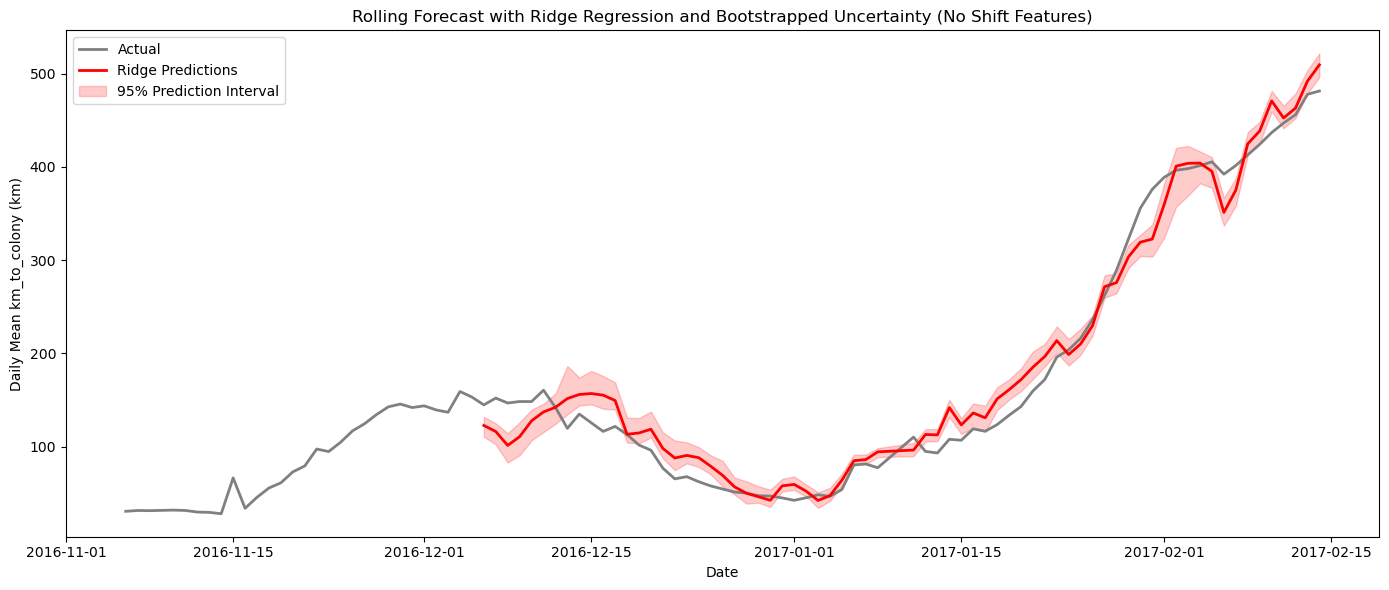

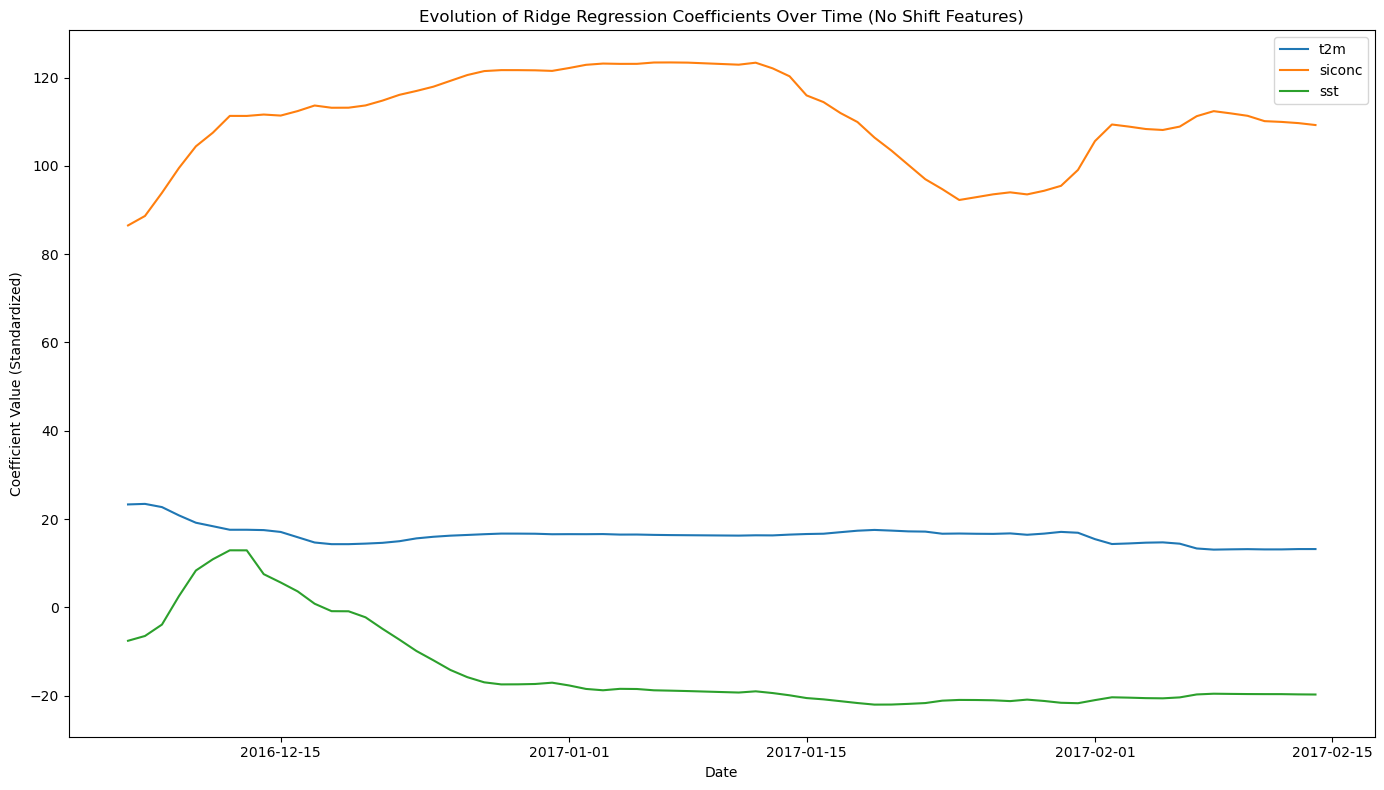

In [ ]:
# =============================================================================
# 1. Data Loading and Preprocessing
# =============================================================================

# Load the penguin data and filter for the King George Island colony of "Adelie Penguin"
df = pd.read_csv("../data/penguin/penguins_final_with_era5.csv")
df = df[(df['common_name'] == 'Adelie Penguin') & 
        (df['colony_name'] == 'King George Island')].copy()
df['date_gmt'] = pd.to_datetime(df['date_gmt'])
df = df.sort_values(by='date_gmt')

# Create additional date features and convert to a daily time series
df['day_of_year'] = df['date_gmt'].dt.dayofyear
df['month'] = df['date_gmt'].dt.month
df['date'] = df['date_gmt'].dt.date

# Aggregate data daily (compute daily averages)
daily_df = df.groupby('date').agg({
    'km_to_colony_mean': 'mean',
    't2m': 'mean',
    'siconc': 'mean',
    'sst': 'mean',
    'month': 'first',
    'day_of_year': 'first'
}).reset_index()
daily_df['n_records'] = df.groupby('date').size().values

# Filter out days with very few observations
min_records_per_day = 1
daily_df = daily_df[daily_df['n_records'] >= min_records_per_day]
print(f"After aggregation, {len(daily_df)} daily observations remain.")

# =============================================================================
# 2. Feature Engineering without Shift (Using Raw Variables Only)
# =============================================================================

# Use only the raw daily weather variables: t2m, siconc, and sst
features = ['t2m', 'siconc', 'sst']
target = 'km_to_colony_mean'

# Drop rows with missing values in the raw weather variables
daily_df = daily_df.dropna(subset=features)

X = daily_df[features]
y = daily_df[target]

# =============================================================================
# 3. Standardize the Features
# =============================================================================

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=features, index=X.index)

# =============================================================================
# 4. Expanding Window Forecast with Ridge Regression and Bootstrapped Uncertainty
# =============================================================================

initial_training_size = 30  # Use the first 30 days to initialize the model
n_bootstrap = 100           # Number of bootstrap iterations for uncertainty estimation

# Lists to store forecasts, prediction intervals, true values, dates, and coefficients
predictions = []      # Point predictions
prediction_lower = [] # Lower bound of the 95% prediction interval
prediction_upper = [] # Upper bound of the 95% prediction interval
actuals = []          # Actual values
dates_list = []       # Dates corresponding to each forecast
coefficients_list = []  # To record Ridge model coefficients over time

# Loop over each day after the initial training period
for i in range(initial_training_size, len(X_scaled)):
    # Define training data: all data up to day i
    X_train = X_scaled.iloc[:i]
    y_train = y.iloc[:i]
    
    # Define test data: the current day (ensure it's a DataFrame)
    X_test = X_scaled.iloc[[i]]
    y_test = y.iloc[i]
    
    # Train a Ridge regression model
    ridge_model = Ridge(alpha=1.0)
    ridge_model.fit(X_train, y_train)
    y_pred = ridge_model.predict(X_test)[0]
    
    # Bootstrapping to estimate prediction uncertainty
    bootstrap_preds = []
    for b in range(n_bootstrap):
        # Resample the training data with replacement
        bootstrap_indices = np.random.choice(X_train.index, size=len(X_train), replace=True)
        X_train_boot = X_train.loc[bootstrap_indices]
        y_train_boot = y_train.loc[bootstrap_indices]
        
        # Refit the Ridge model on the bootstrap sample
        boot_model = Ridge(alpha=1.0)
        boot_model.fit(X_train_boot, y_train_boot)
        
        # Predict on the test day and store the prediction
        bootstrap_preds.append(boot_model.predict(X_test)[0])
    bootstrap_preds = np.array(bootstrap_preds)
    
    # Compute the 2.5th and 97.5th percentiles for the 95% prediction interval
    lower_bound = np.percentile(bootstrap_preds, 2.5)
    upper_bound = np.percentile(bootstrap_preds, 97.5)
    
    # Record results
    predictions.append(y_pred)
    prediction_lower.append(lower_bound)
    prediction_upper.append(upper_bound)
    actuals.append(y_test)
    dates_list.append(daily_df.iloc[i]['date'])
    coefficients_list.append(ridge_model.coef_)

# Evaluate overall performance
overall_r2 = r2_score(actuals, predictions)
overall_rmse = np.sqrt(mean_squared_error(actuals, predictions))
print(f"Overall R²: {overall_r2:.3f}, Overall RMSE: {overall_rmse:.3f}")

# Convert forecast dates to datetime objects for plotting
dates_dt = pd.to_datetime(dates_list)

# =============================================================================
# 5. Visualization of Predictions with Uncertainty
# =============================================================================

plt.figure(figsize=(14,6))
# Plot the actual daily mean distances (gray line)
plt.plot(daily_df['date'], daily_df[target], label='Actual', color='gray', linewidth=2)
# Plot the rolling Ridge predictions (red line)
plt.plot(dates_dt, predictions, label='Ridge Predictions', color='red', linewidth=2)
# Fill between the prediction lower and upper bounds (95% prediction interval)
plt.fill_between(dates_dt, prediction_lower, prediction_upper, color='red', alpha=0.2,
                 label='95% Prediction Interval')
plt.xlabel("Date")
plt.ylabel("Daily Mean km_to_colony (km)")
plt.title("Rolling Forecast with Ridge Regression and Bootstrapped Uncertainty (No Shift Features)")
plt.legend()
plt.tight_layout()
plt.show()

# =============================================================================
# 6. Visualization of the Evolution of Ridge Regression Coefficients Over Time
# =============================================================================

# Create a DataFrame with recorded coefficients; rows correspond to forecast dates
coef_df = pd.DataFrame(coefficients_list, columns=features, index=dates_dt)

plt.figure(figsize=(14,8))
for feature in features:
    plt.plot(coef_df.index, coef_df[feature], label=feature)
plt.xlabel("Date")
plt.ylabel("Coefficient Value (Standardized)")
plt.title("Evolution of Ridge Regression Coefficients Over Time (No Shift Features)")
plt.legend()
plt.tight_layout()
plt.show()


## Shap interpretation

In [208]:
explainer = shap.LinearExplainer(ridge_model, X_scaled)  
shap_values = explainer.shap_values(X_scaled)


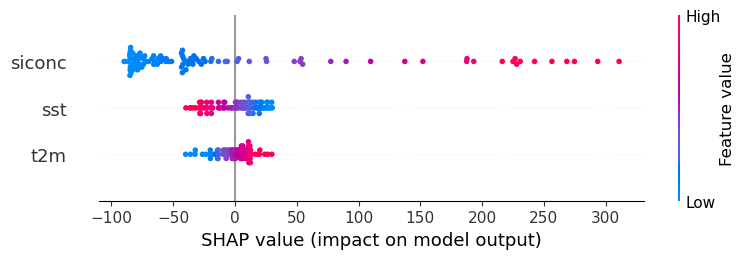

In [209]:
shap.summary_plot(shap_values, X_scaled)